# ARIMAX Forecast Notebook

This notebook performs data loading, feature engineering, ARIMAX model training, forecasting, and evaluation.


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import holidays
import calendar
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Optional: set matplotlib inline if using a Jupyter Notebook
%matplotlib inline


In [55]:
# -------------------------------
# 1. Data Loading and Aggregation (Monthly)
# -------------------------------
df_monthly = pd.read_csv("../api_data/monthly_api_data.csv")

# Convert consumption to kWh
df_monthly["Consumption"] = round(df_monthly["Consumption"] / 1000, 4)
df_monthly["Month"] = pd.to_datetime(df_monthly["Month"], format="%Y-%m")
df_monthly.sort_values("Month", inplace=True)

# Group by Month & Measurement, then sum consumption across phases
df_grouped = df_monthly.groupby(["Month", "Measurement"])["Consumption"].sum().unstack(fill_value=0)

# Ensure required measurements exist
for col in ["Grid Organi lbc", "Chargers", "Chargers achteraan"]:
    if col not in df_grouped.columns:
        df_grouped[col] = 0

# Use "Grid Organi lbc" as the total consumption (your forecast target)
#df_grouped["Total_charger_consumption"] = df_grouped["Chargers"] + df_grouped["Chargers achteraan"]


df_grouped['Total_consumption'] = df_grouped['Grid Organi lbc']
df_grouped.reset_index(inplace=True)

# Add year and month (number) for later merging
df_grouped["year"] = df_grouped["Month"].dt.year
df_grouped["month"] = df_grouped["Month"].dt.month
df_grouped["month_number"] = df_grouped["Month"].dt.month


In [56]:
# -------------------------------
# 2. Basic Feature Engineering on Monthly Data
# -------------------------------
be_holidays = holidays.BE()

def count_holidays_and_weekends(ts):
    year, month = ts.year, ts.month
    _, last_day = calendar.monthrange(year, month)
    start_date = pd.Timestamp(year=year, month=month, day=1)
    end_date = pd.Timestamp(year=year, month=month, day=last_day)
    days = pd.date_range(start_date, end_date, freq="D")
    holiday_count = sum(1 for day in days if day in be_holidays)
    weekend_count = sum(1 for day in days if day.weekday() >= 5)
    return pd.Series({"holiday_count": holiday_count, "weekend_count": weekend_count})

df_grouped[["holiday_count", "weekend_count"]] = df_grouped["Month"].apply(count_holidays_and_weekends)

# Additional monthly features
# Adjust lag features (these are already safe because they use past data)
df_grouped["lag_1"] = df_grouped["Total_consumption"].shift(1)
df_grouped["lag_12"] = df_grouped["Total_consumption"].shift(12)

# Compute rolling means using only past data by shifting before the rolling window
df_grouped["rolling_mean_3"] = df_grouped["Total_consumption"].shift(1).rolling(window=3).mean()
df_grouped["rolling_mean_6"] = df_grouped["Total_consumption"].shift(1).rolling(window=6).mean()

# Compute the rolling residual as the difference between the lagged target and the rolling mean
df_grouped["rolling_resid_3"] = df_grouped["Total_consumption"].shift(1) - df_grouped["rolling_mean_3"]

# Compute month-over-month change using shifted values
df_grouped["mom_change"] = df_grouped["Total_consumption"].shift(1).pct_change()

df_grouped["month_sin"] = np.sin(2 * np.pi * df_grouped["month_number"] / 12)
df_grouped["month_cos"] = np.cos(2 * np.pi * df_grouped["month_number"] / 12)
df_grouped["trend_index"] = np.arange(len(df_grouped))
df_grouped["weekend_month_interaction"] = df_grouped["weekend_count"] * df_grouped["month_number"]
df_grouped["holiday_lag1_interaction"] = df_grouped["holiday_count"] * df_grouped["lag_1"]





Dropping the last incomplete month of February.


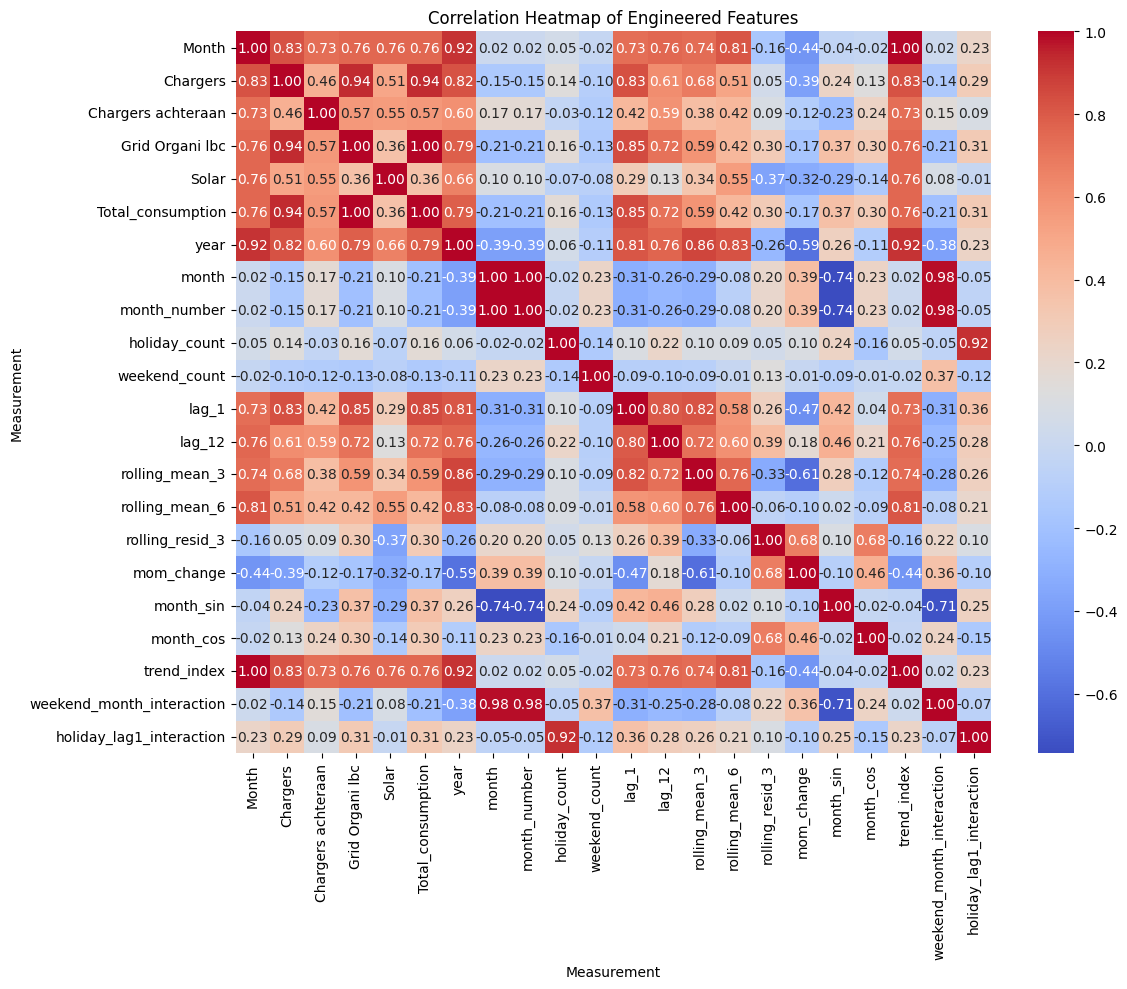

In [57]:
# -------------------------------
# 4.5. Drop the Last Month if It Is an Incomplete February
# -------------------------------
if df_grouped["Month"].iloc[-1].month == 2:
    print("Dropping the last incomplete month of February.")
    df_grouped = df_grouped.iloc[:-1].copy()

# -------------------------------
# 5. Correlation Heatmap
# -------------------------------
plt.figure(figsize=(12, 10))
corr_matrix = df_grouped.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Engineered Features")
plt.tight_layout()
plt.show()


In [58]:
# -------------------------------
# 6. Define Target and Exogenous Variables
# -------------------------------
target = "Total_consumption"

exog_features = [
    "holiday_count", "weekend_count", "month_number", "year",
    "lag_1", "lag_12", "rolling_mean_3", "rolling_mean_6",
    "rolling_resid_3", "mom_change", "month_sin", "month_cos",
    "trend_index", "weekend_month_interaction", "holiday_lag1_interaction"
]

y = df_grouped[target]
exog = df_grouped[exog_features]

# Ensure no infs or NaNs are in exog
exog.replace([np.inf, -np.inf], np.nan, inplace=True)
exog.fillna(0, inplace=True)


C:\Users\user\AppData\Local\Temp\ipykernel_6776\1500821452.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\user\AppData\Local\Temp\ipykernel_6776\1500821452.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exog.fillna(0, inplace=True)


In [59]:
# -------------------------------
# 7. Train-Test Split (80/20)
# -------------------------------
split_index = int(0.82 * len(df_grouped))
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]
exog_train, exog_test = exog.iloc[:split_index], exog.iloc[split_index:]

print(f"Training data from {df_grouped['Month'].iloc[0].date()} to {df_grouped['Month'].iloc[split_index-1].date()}")
print(f"Testing data from {df_grouped['Month'].iloc[split_index].date()} to {df_grouped['Month'].iloc[-1].date()}")


Training data from 2022-09-01 to 2024-07-01
Testing data from 2024-08-01 to 2025-01-01


In [60]:
# -------------------------------
# 8. ARIMAX Model Training Using Auto-ARIMA
# -------------------------------
model_auto = auto_arima(
    y_train,
    exogenous=exog_train,
    seasonal=False,       # Change to True and set m if seasonality exists
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)
print("Optimal ARIMA order:", model_auto.order)

order = model_auto.order  # e.g., (1, 1, 1)
model = SARIMAX(
    y_train,
    exog=exog_train,
    order=order,
    enforce_stationarity=False,
    enforce_invertibility=True
)
model_fit = model.fit(disp=False)


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=410.607, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=408.644, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=409.670, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=409.405, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=407.519, Time=0.01 sec


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=411.368, Time=0.13 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.465 seconds
Optimal ARIMA order: (0, 1, 0)


c:\Users\user\enviroments\Stage_project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [61]:
# -------------------------------
# 9. Forecasting and Evaluation
# -------------------------------
y_pred = model_fit.forecast(steps=len(y_test), exog=exog_test)

def calculate_mape(y_true, y_pred):
    epsilon = 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true + epsilon))) * 100

def calculate_smape(y_true, y_pred):
    denominator = np.abs(y_true) + np.abs(y_pred) + 1e-10
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

def calculate_mase(y_true, y_pred, y_train):
    naive_errors = np.abs(np.diff(y_train))
    d = naive_errors.mean() if len(naive_errors) > 0 else 1e-10
    return np.mean(np.abs(y_true - y_pred)) / (d + 1e-10)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = calculate_mape(y_test.values, y_pred.values)
smape = calculate_smape(y_test.values, y_pred.values)
mase = calculate_mase(y_test.values, y_pred.values, y_train.values)

# Additional error metrics
rmse = np.sqrt(mse)
nrmse = rmse / (y_test.max() - y_test.min())
r2 = r2_score(y_test, y_pred)
n = len(y_test)
p = exog_test.shape[1]
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f"MAE:   {mae:.2f}")
print(f"MSE:   {mse:.2f}")
print(f"MAPE:  {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")
print(f"MASE:  {mase:.2f}")
print(f"RMSE:  {rmse:.2f}")
print(f"NRMSE: {nrmse:.4f}")
print(f"R²:    {r2:.4f}")
print(f"Adjusted R²: {r2_adj:.4f}")


MAE:   1442.70
MSE:   3700370.46
MAPE:  7.29%
sMAPE: 7.79%
MASE:  0.79
RMSE:  1923.63
NRMSE: 0.1462
R²:    0.7986
Adjusted R²: 1.1007


In [62]:
# -------------------------------
# 10. Exporting Predictions to CSV (in kWh)
# -------------------------------
forecast_df = pd.DataFrame({
    "Month": df_grouped["Month"].iloc[split_index:].values,
    "Real_Consumption_kWh": y_test.values,
    "Predicted_Charger_Consumption_kWh": y_pred.values
})
forecast_df["Difference"] = forecast_df["Predicted_Charger_Consumption_kWh"] - forecast_df["Real_Consumption_kWh"]
forecast_df = forecast_df.round(4)
forecast_df.to_csv("../results/arimax/predicted_charger_values_kwh_withoutweekly.csv", index=False)
print("Predicted values have been saved to 'predicted_charger_values_kwh_withoutweekly.csv'.")


Predicted values have been saved to 'predicted_charger_values_kwh_withoutweekly.csv'.


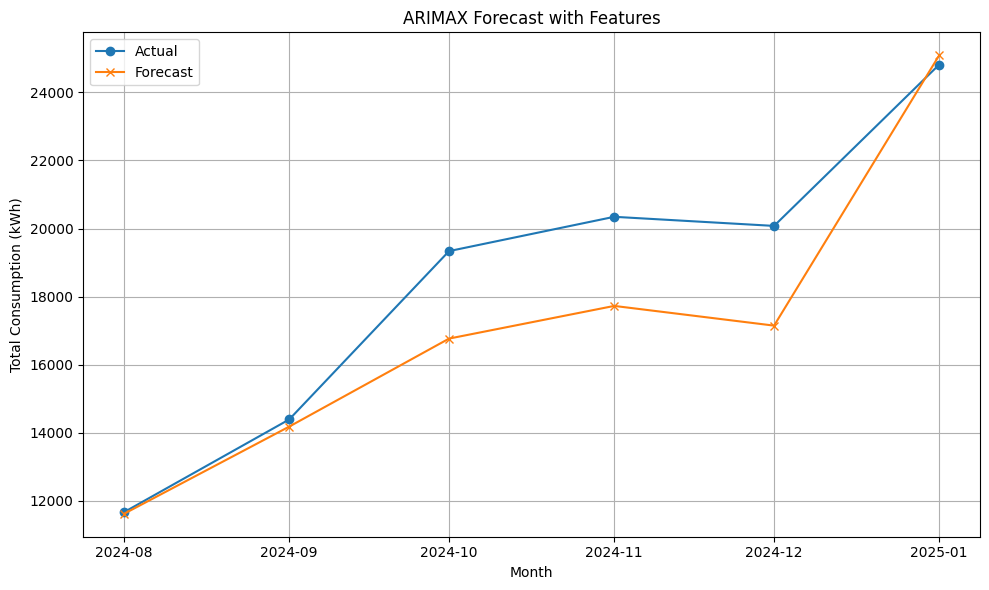

In [63]:
# -------------------------------
# 11. Plotting the Forecast
# -------------------------------
plt.figure(figsize=(10, 6))
plt.plot(df_grouped["Month"].iloc[split_index:], y_test, label="Actual", marker="o")
plt.plot(df_grouped["Month"].iloc[split_index:], y_pred, label="Forecast", marker="x")
plt.xlabel("Month")
plt.ylabel("Total Consumption (kWh)")
plt.title("ARIMAX Forecast with Features")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
